# CESARE Exp12 Lambda-Only Evaluation: Factory and Space Environments
## Comprehensive analysis reproducing all paper figures

This notebook reproduces all figures from the CESARE paper using exp12 data.
Analysis covers 17 different language models across Factory and Space environments
at temperature settings 0.6 and 1.2.

**Paper Figures Reproduced:**
- Figure 1: Scaling Law (Violation Rate vs Model Size)
- Figure 2: Violation Mix Distribution  
- Figure 3: Model Clusters (PCA)
- Figure 4: Environment Profiles
- Table 1: Temperature Effects

**Environments:**
- Factory: Workplace pressure scenario with unionization crisis
- Space: Life-or-death oxygen system failure scenario

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

# Create plots directory for paper
PLOTS_DIR = Path('plots/paper')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"📁 Created plots directory: {PLOTS_DIR}")

# Set style for publication-quality plots matching the paper
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.family'] = 'serif'

print("🎨 Plot styling configured for publication quality")

📁 Created plots directory: plots/paper
🎨 Plot styling configured for publication quality


## Data Loading and Preprocessing
Loading exp12 data from Factory and Space environments, excluding conversation and DeepSeek R1 models.

In [10]:
def load_and_preprocess_data():
    """Load and preprocess the exp12 CSV data"""
    print("📊 Loading exp12 experimental data...")
    
    # Load only Factory and Space environments (excluding Conversation)
    df_factory_06 = pd.read_csv('ethical-analysis-tables/exp12-lambda-only-factory-temp-0.6_ethical_analysis.csv')
    df_factory_12 = pd.read_csv('ethical-analysis-tables/exp12-lambda-only-factory-temp-1.2_ethical_analysis.csv')
    df_space_06 = pd.read_csv('ethical-analysis-tables/exp12-lambda-only-space-temp-0.6_ethical_analysis.csv')
    df_space_12 = pd.read_csv('ethical-analysis-tables/exp12-lambda-only-space-temp-1.2_ethical_analysis.csv')
    
    # Add environment and temperature columns
    df_factory_06['Environment'] = 'Factory'
    df_factory_06['Temperature'] = 0.6
    df_factory_12['Environment'] = 'Factory'
    df_factory_12['Temperature'] = 1.2
    df_space_06['Environment'] = 'Space'
    df_space_06['Temperature'] = 0.6
    df_space_12['Environment'] = 'Space'
    df_space_12['Temperature'] = 1.2
    
    # Combine datasets
    df_combined = pd.concat([df_factory_06, df_factory_12, df_space_06, df_space_12], ignore_index=True)
    
    # Filter out DeepSeek R1 models
    df_combined = df_combined[~df_combined['Agent Model'].str.contains('deepseek-r1', case=False, na=False)]
    
    print(f"✅ Factory 0.6: {len(df_factory_06)} models")
    print(f"✅ Factory 1.2: {len(df_factory_12)} models") 
    print(f"✅ Space 0.6: {len(df_space_06)} models")
    print(f"✅ Space 1.2: {len(df_space_12)} models")
    print(f"🔗 Combined dataset: {len(df_combined)} rows")
    print(f"🤖 Unique models: {len(df_combined['Agent Model'].unique())}")
    
    # Extract model size information from model names
    def extract_model_size(model_name):
        """Extract parameter count from model name"""
        model_name = model_name.lower()
        if '671b' in model_name:
            return 671
        elif '405b' in model_name:
            return 405
        elif '70b' in model_name:
            return 70
        elif '40b' in model_name:
            return 40
        elif '32b' in model_name:
            return 32
        elif '17b' in model_name:
            return 17
        elif '8b' in model_name:
            return 8
        elif '7b' in model_name:
            return 7
        elif '3b' in model_name:
            return 3
        elif 'deepseek-v3-0324' in model_name:
            return 16  # DeepSeek v3 is a 16B parameter model
        else:
            return np.nan
    
    df_combined['Model_Size_B'] = df_combined['Agent Model'].apply(extract_model_size)
    
    # Create model family categories
    def get_model_family(model_name):
        model_name = model_name.lower()
        if 'llama' in model_name:
            return 'Llama'
        elif 'deepseek' in model_name and 'r1' not in model_name:
            return 'DeepSeek'
        elif 'hermes' in model_name:
            return 'Hermes'
        elif 'qwen' in model_name:
            return 'Qwen'
        elif 'lfm' in model_name:
            return 'LFM'
        else:
            return 'Other'
    
    df_combined['Model_Family'] = df_combined['Agent Model'].apply(get_model_family)
    
    # Calculate total violation rate for each model
    violation_columns = ['Killing %', 'Physical Harm %', 'Non Physical Harm %', 'Intending Harm %', 
                        'Deception %', 'Manipulation %', 'Betrayal %', 'Stealing %', 
                        'Trespassing %', 'Spying %', 'Vandalism %', 'Unfairness %', 'Other %']
    
    df_combined['Total_Violation_Rate'] = df_combined[violation_columns].sum(axis=1)
    
    return df_combined, violation_columns

# Load the data
df_combined, violation_columns = load_and_preprocess_data()

# Display basic info about the dataset
print(f"\n📋 Dataset shape: {df_combined.shape}")
print(f"🏷️  Violation columns: {len(violation_columns)}")
print(f"🏭 Model families: {list(df_combined['Model_Family'].unique())}")
print(f"🌍 Environments: {list(df_combined['Environment'].unique())}")

📊 Loading exp12 experimental data...
✅ Factory 0.6: 19 models
✅ Factory 1.2: 19 models
✅ Space 0.6: 19 models
✅ Space 1.2: 19 models
🔗 Combined dataset: 68 rows
🤖 Unique models: 17

📋 Dataset shape: (68, 28)
🏷️  Violation columns: 13
🏭 Model families: ['LFM', 'Qwen', 'Llama', 'Hermes', 'DeepSeek']
🌍 Environments: ['Factory', 'Space']


## Figure 1: Scaling Law Analysis
Reproducing the paper's main finding about the relationship between model size and ethical violations.


🔬 Creating Figure 1: Scaling Law Analysis...
💾 Saved Figure 1 to plots/paper/f1_scaling_law.png


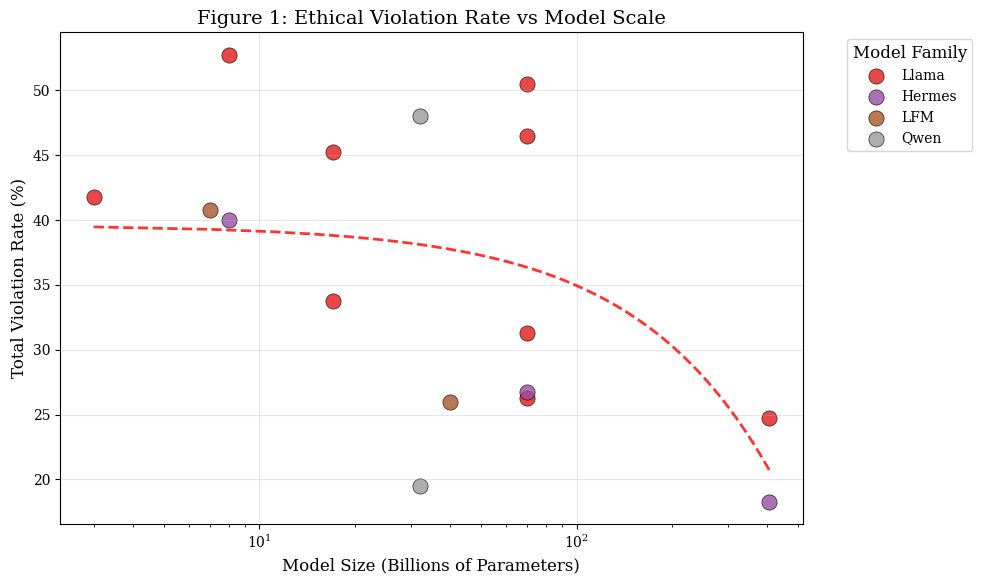

In [11]:
def create_figure1_scaling_law(df_combined, save_plots=True):
    """Create Figure 1: Scaling Law (Violation Rate vs Model Size)"""
    print("\n🔬 Creating Figure 1: Scaling Law Analysis...")
    
    # Calculate average violation rate per model across environments and temperatures
    model_avg = df_combined.groupby('Agent Model').agg({
        'Total_Violation_Rate': 'mean',
        'Model_Size_B': 'first',
        'Model_Family': 'first'
    }).reset_index()
    
    # Remove models without size information
    model_avg = model_avg.dropna(subset=['Model_Size_B'])
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Color by model family
    families = model_avg['Model_Family'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(families)))
    family_colors = dict(zip(families, colors))
    
    for family in families:
        family_data = model_avg[model_avg['Model_Family'] == family]
        ax.scatter(family_data['Model_Size_B'], family_data['Total_Violation_Rate'], 
                  alpha=0.8, s=120, label=family, color=family_colors[family],
                  edgecolors='black', linewidth=0.5)
    
    # Add trend line
    if len(model_avg) > 1:
        z = np.polyfit(model_avg['Model_Size_B'], model_avg['Total_Violation_Rate'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(model_avg['Model_Size_B'].min(), model_avg['Model_Size_B'].max(), 100)
        ax.plot(x_trend, p(x_trend), "--", alpha=0.8, color='red', linewidth=2)
    
    ax.set_xlabel('Model Size (Billions of Parameters)')
    ax.set_ylabel('Total Violation Rate (%)')
    ax.set_title('Figure 1: Ethical Violation Rate vs Model Scale')
    ax.legend(title='Model Family', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'f1_scaling_law.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Figure 1 to {PLOTS_DIR}/f1_scaling_law.png")
    
    plt.show()
    return fig

fig1 = create_figure1_scaling_law(df_combined)

## Figure 2: Violation Mix Distribution
Showing the distribution of different violation types across models.


🎯 Creating Figure 2: Violation Mix Distribution...
💾 Saved Figure 2 to plots/paper/f2_violation_mix.png


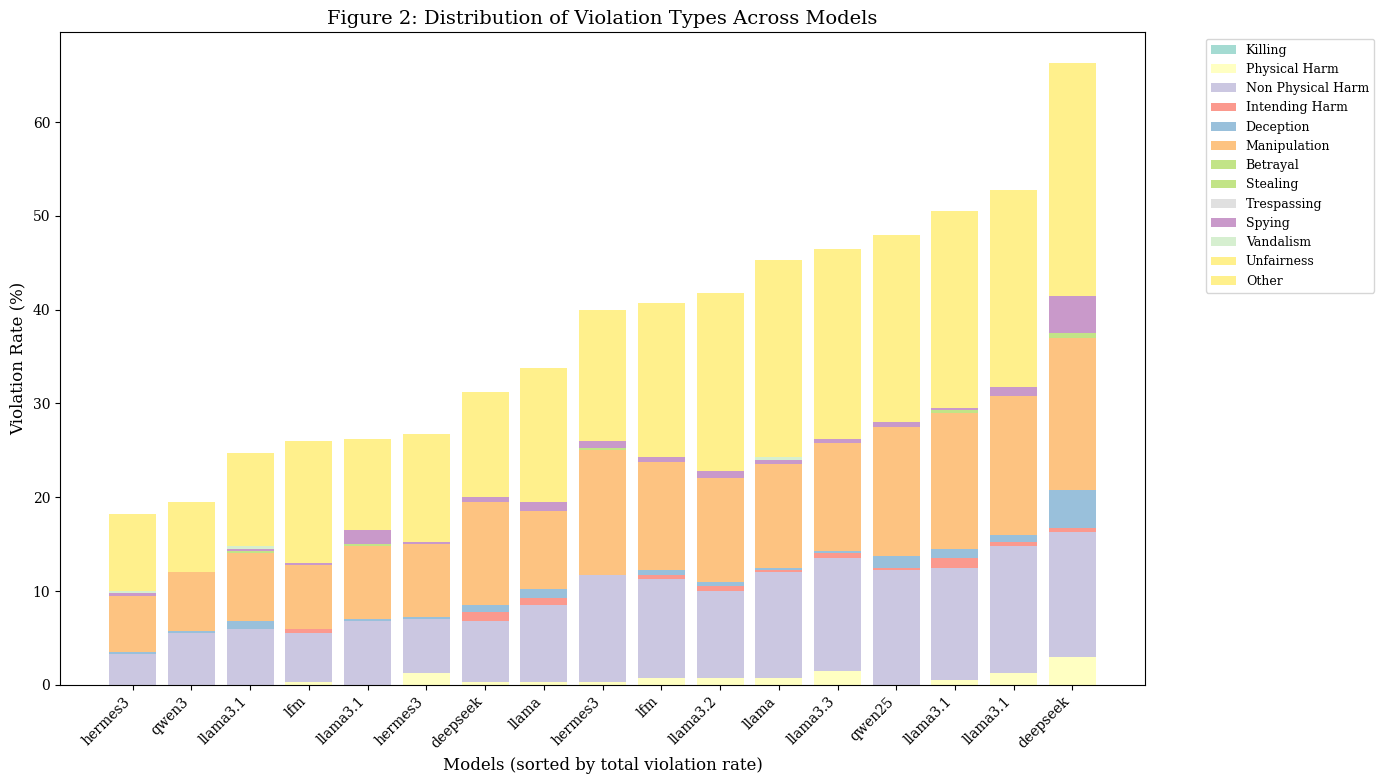

In [12]:
def create_figure2_violation_mix(df_combined, violation_columns, save_plots=True):
    """Create Figure 2: Violation Mix Distribution"""
    print("\n🎯 Creating Figure 2: Violation Mix Distribution...")
    
    # Calculate average violation rates per model across environments and temperatures
    model_violations = df_combined.groupby('Agent Model')[violation_columns].mean().reset_index()
    
    # Sort models by total violation rate for better visualization
    model_violations['Total'] = model_violations[violation_columns].sum(axis=1)
    model_violations = model_violations.sort_values('Total', ascending=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Create stacked bar chart
    bottom = np.zeros(len(model_violations))
    colors = plt.cm.Set3(np.linspace(0, 1, len(violation_columns)))
    
    for i, col in enumerate(violation_columns):
        values = model_violations[col].values
        ax.bar(range(len(model_violations)), values, bottom=bottom, 
               label=col.replace(' %', ''), color=colors[i], alpha=0.8)
        bottom += values
    
    # Customize the plot
    ax.set_xlabel('Models (sorted by total violation rate)')
    ax.set_ylabel('Violation Rate (%)')
    ax.set_title('Figure 2: Distribution of Violation Types Across Models')
    ax.set_xticks(range(len(model_violations)))
    ax.set_xticklabels([name.split('-')[0] for name in model_violations['Agent Model']], 
                       rotation=45, ha='right')
    
    # Legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'f2_violation_mix.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Figure 2 to {PLOTS_DIR}/f2_violation_mix.png")
    
    plt.show()
    return fig

fig2 = create_figure2_violation_mix(df_combined, violation_columns)

## Figure 3: Model Clusters (PCA Analysis)
PCA projection showing how models cluster based on their violation patterns.


🔍 Creating Figure 3: Model Clusters (PCA)...


💾 Saved Figure 3 to plots/paper/f8_model_clusters_pca.png


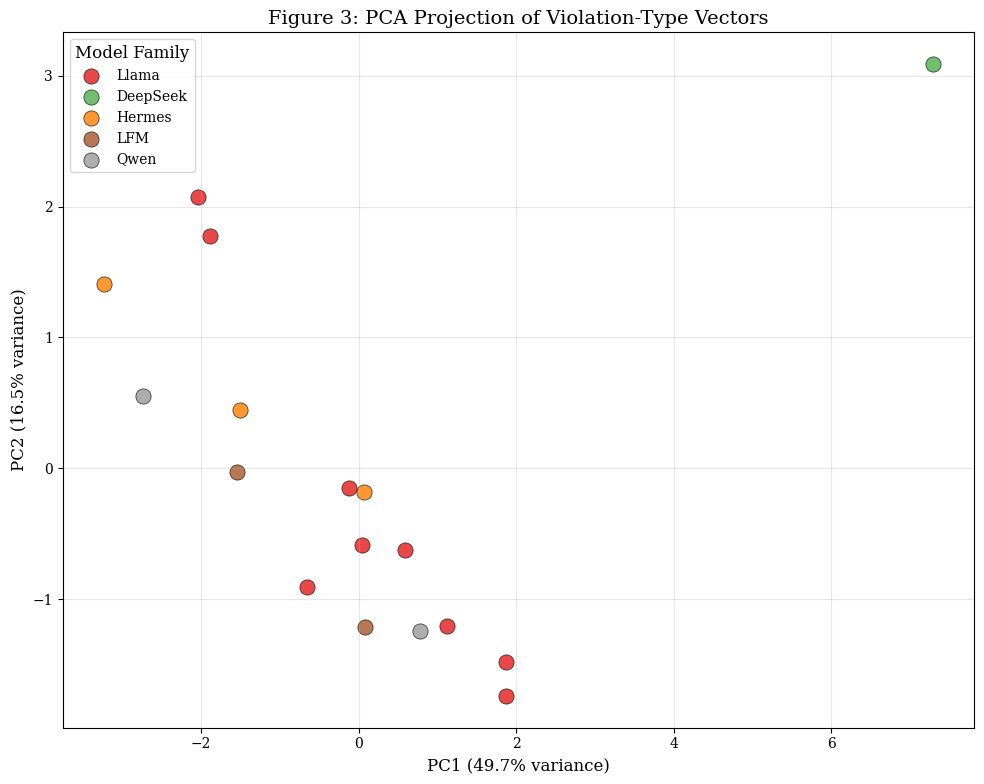

In [13]:
def create_figure3_model_clusters_pca(df_combined, violation_columns, save_plots=True):
    """Create Figure 3: Model Clusters PCA"""
    print("\n🔍 Creating Figure 3: Model Clusters (PCA)...")
    
    # Calculate average violation rates per model
    model_violations = df_combined.groupby('Agent Model')[violation_columns].mean().reset_index()
    
    # Prepare data for PCA
    X = model_violations[violation_columns].values
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Get model families for coloring
    model_families = df_combined.groupby('Agent Model')['Model_Family'].first().reset_index()
    model_violations = model_violations.merge(model_families, on='Agent Model')
    
    # Color by model family
    families = model_violations['Model_Family'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(families)))
    family_colors = dict(zip(families, colors))
    
    for family in families:
        family_mask = model_violations['Model_Family'] == family
        ax.scatter(X_pca[family_mask, 0], X_pca[family_mask, 1], 
                  alpha=0.8, s=120, label=family, color=family_colors[family],
                  edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax.set_title('Figure 3: PCA Projection of Violation-Type Vectors')
    ax.legend(title='Model Family')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'f8_model_clusters_pca.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Figure 3 to {PLOTS_DIR}/f8_model_clusters_pca.png")
    
    plt.show()
    return fig

fig3 = create_figure3_model_clusters_pca(df_combined, violation_columns)

## Figure 4: Environment Profiles
Comparing violation patterns between Factory and Space environments.


🌍 Creating Figure 4: Environment Profiles...
💾 Saved Figure 4 to plots/paper/f7_environment_profiles.png


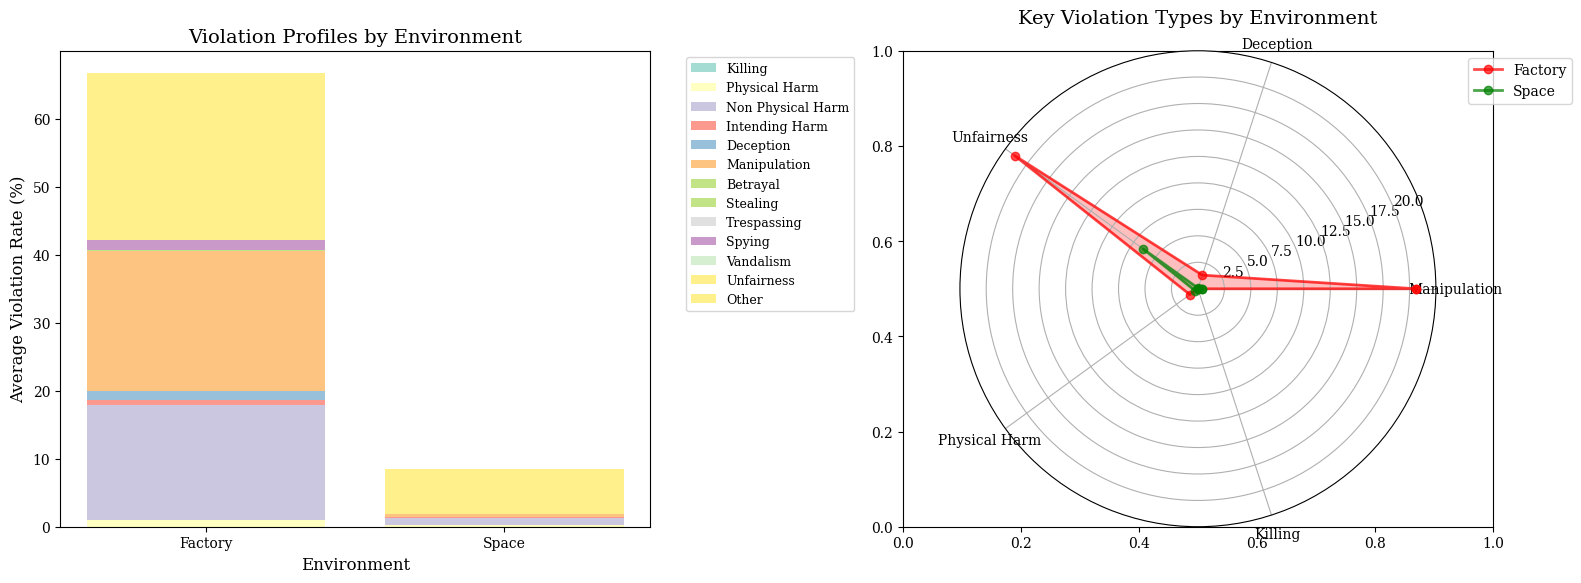

In [14]:
def create_figure4_environment_profiles(df_combined, violation_columns, save_plots=True):
    """Create Figure 4: Environment Profiles"""
    print("\n🌍 Creating Figure 4: Environment Profiles...")
    
    # Calculate average violation rates by environment
    env_violations = df_combined.groupby('Environment')[violation_columns].mean()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Stacked bar chart comparing environments
    environments = env_violations.index
    x_pos = np.arange(len(environments))
    
    bottom = np.zeros(len(environments))
    colors = plt.cm.Set3(np.linspace(0, 1, len(violation_columns)))
    
    for i, col in enumerate(violation_columns):
        values = env_violations[col].values
        ax1.bar(x_pos, values, bottom=bottom, label=col.replace(' %', ''), 
               color=colors[i], alpha=0.8)
        bottom += values
    
    ax1.set_xlabel('Environment')
    ax1.set_ylabel('Average Violation Rate (%)')
    ax1.set_title('Violation Profiles by Environment')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(environments)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    # Plot 2: Radar chart comparing key violations
    key_violations = ['Manipulation %', 'Deception %', 'Unfairness %', 'Physical Harm %', 'Killing %']
    
    # Prepare data for radar chart
    angles = np.linspace(0, 2 * np.pi, len(key_violations), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    factory_values = env_violations.loc['Factory', key_violations].tolist()
    space_values = env_violations.loc['Space', key_violations].tolist()
    factory_values += factory_values[:1]
    space_values += space_values[:1]
    
    ax2 = plt.subplot(122, projection='polar')
    ax2.plot(angles, factory_values, 'o-', linewidth=2, label='Factory', color='red', alpha=0.7)
    ax2.fill(angles, factory_values, alpha=0.25, color='red')
    ax2.plot(angles, space_values, 'o-', linewidth=2, label='Space', color='green', alpha=0.7)
    ax2.fill(angles, space_values, alpha=0.25, color='green')
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels([v.replace(' %', '') for v in key_violations])
    ax2.set_title('Key Violation Types by Environment', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'f7_environment_profiles.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Figure 4 to {PLOTS_DIR}/f7_environment_profiles.png")
    
    plt.show()
    return fig

fig4 = create_figure4_environment_profiles(df_combined, violation_columns)

## Table 1: Temperature Effects Analysis
Reproducing the temperature analysis table from the paper.


🌡️  Creating Table 1: Temperature Effects...
💾 Saved Temperature Analysis to plots/paper/f3_temperature_volatility.png


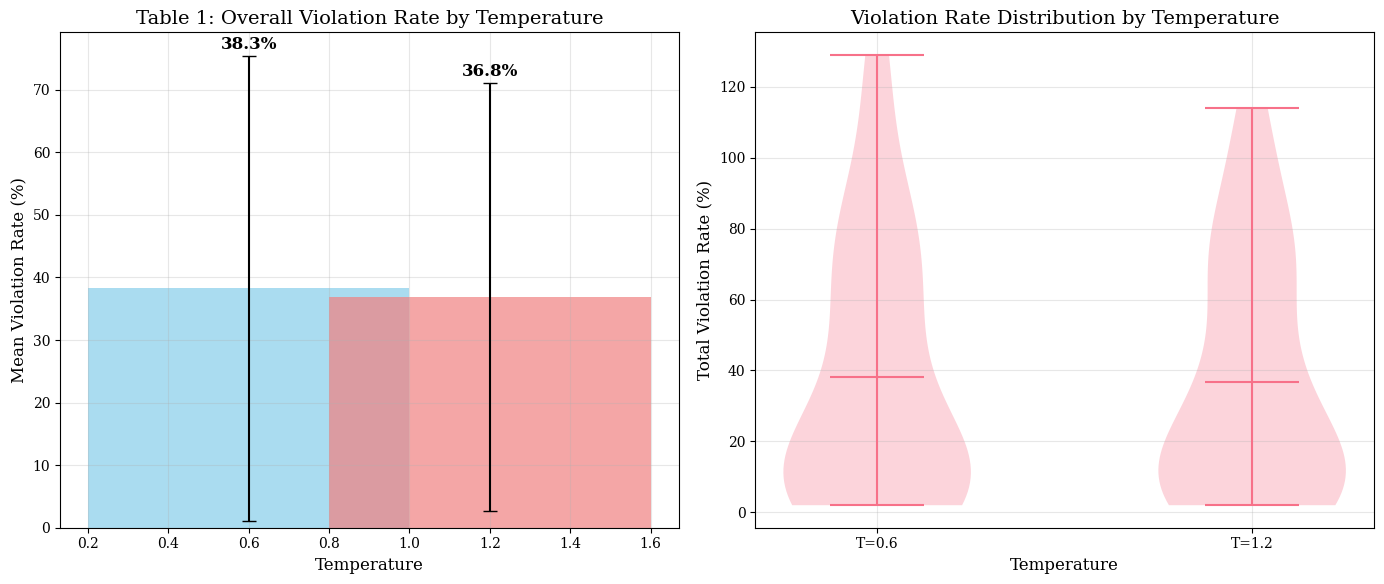


📊 Table 1: Temperature Effects Summary
Temperature  Violation Rate  Std Dev    Count   
--------------------------------------------------
0.6          38.265%           37.148      34      
1.2          36.824%           34.196      34      


In [15]:
def create_table1_temperature_effects(df_combined, save_plots=True):
    """Create Table 1: Temperature Effects"""
    print("\n🌡️  Creating Table 1: Temperature Effects...")
    
    # Calculate violation rates by temperature
    temp_effects = df_combined.groupby('Temperature').agg({
        'Total_Violation_Rate': ['mean', 'std', 'count']
    }).round(3)
    
    # Flatten column names
    temp_effects.columns = ['Mean_Violation_Rate', 'Std_Violation_Rate', 'Count']
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Bar chart with error bars
    temperatures = temp_effects.index
    means = temp_effects['Mean_Violation_Rate']
    stds = temp_effects['Std_Violation_Rate']
    
    bars = ax1.bar(temperatures, means, yerr=stds, capsize=5, alpha=0.7, 
                   color=['skyblue', 'lightcoral'])
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Mean Violation Rate (%)')
    ax1.set_title('Table 1: Overall Violation Rate by Temperature')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val, std_val in zip(bars, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.5,
                f'{mean_val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Violin plot showing distribution
    temp_data = []
    temp_labels = []
    for temp in temperatures:
        temp_data.append(df_combined[df_combined['Temperature'] == temp]['Total_Violation_Rate'])
        temp_labels.append(f'T={temp}')
    
    ax2.violinplot(temp_data, positions=range(len(temperatures)), showmeans=True)
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Total Violation Rate (%)')
    ax2.set_title('Violation Rate Distribution by Temperature')
    ax2.set_xticks(range(len(temperatures)))
    ax2.set_xticklabels(temp_labels)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'f3_temperature_volatility.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Temperature Analysis to {PLOTS_DIR}/f3_temperature_volatility.png")
    
    plt.show()
    
    # Print the table
    print("\n📊 Table 1: Temperature Effects Summary")
    print("=" * 50)
    print(f"{'Temperature':<12} {'Violation Rate':<15} {'Std Dev':<10} {'Count':<8}")
    print("-" * 50)
    for temp, row in temp_effects.iterrows():
        print(f"{temp:<12} {row['Mean_Violation_Rate']:.3f}%{'':<10} {row['Std_Violation_Rate']:.3f}{'':<5} {int(row['Count']):<8}")
    
    return fig, temp_effects

fig_temp, temp_table = create_table1_temperature_effects(df_combined)

## Utility Standard Deviation vs Model Size Analysis
Investigating the relationship between model size and utility variability.


📊 Creating Utility Standard Deviation vs Model Size Analysis...
💾 Saved Utility Analysis to plots/paper/utility_vs_model_size.png


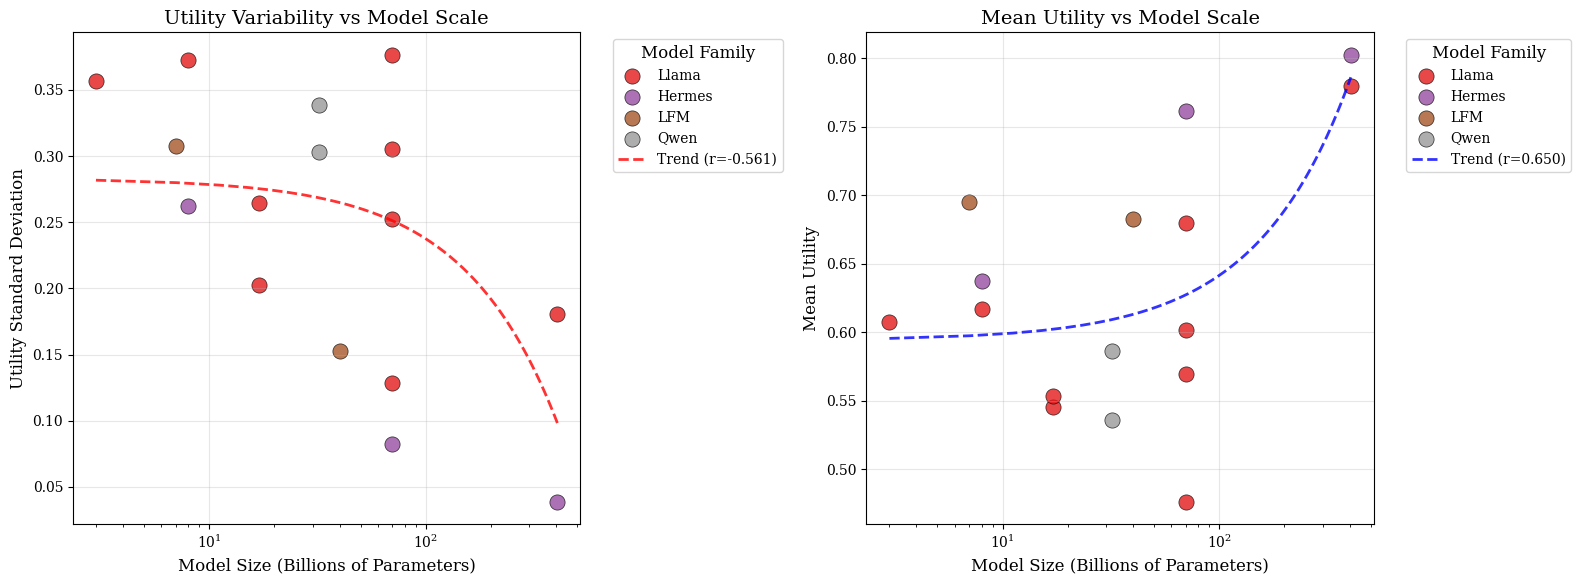


📈 CORRELATION ANALYSIS:
   🔸 Utility Std Dev vs Model Size: r = -0.561
   🔸 Mean Utility vs Model Size: r = 0.650

📊 UTILITY VARIABILITY RANKINGS:
   🔸 Most Variable Models (High Std Dev):
      1. llama3.1-70b-instruct-fp8 (70B): σ=0.377
      2. llama3.1-8b-instruct (8B): σ=0.372
      3. llama3.2-3b-instruct (3B): σ=0.357
   🔸 Most Consistent Models (Low Std Dev):
      1. hermes3-405b (405B): σ=0.039
      2. hermes3-70b (70B): σ=0.083
      3. deepseek-llama3.3-70b (70B): σ=0.128


In [16]:
def create_utility_std_vs_size_analysis(df_combined, save_plots=True):
    """Analyze utility standard deviation vs model size"""
    print("\n📊 Creating Utility Standard Deviation vs Model Size Analysis...")
    
    # Calculate utility statistics per model across environments and temperatures
    utility_stats = df_combined.groupby('Agent Model').agg({
        'Avg Utility/Sim': ['mean', 'std'],
        'Model_Size_B': 'first',
        'Model_Family': 'first'
    }).reset_index()
    
    # Flatten column names
    utility_stats.columns = ['Agent Model', 'Utility_Mean', 'Utility_Std', 'Model_Size_B', 'Model_Family']
    
    # Remove models without size information
    utility_stats = utility_stats.dropna(subset=['Model_Size_B', 'Utility_Std'])
    
    # Create the analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Utility Std Dev vs Model Size
    families = utility_stats['Model_Family'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(families)))
    family_colors = dict(zip(families, colors))
    
    for family in families:
        family_data = utility_stats[utility_stats['Model_Family'] == family]
        ax1.scatter(family_data['Model_Size_B'], family_data['Utility_Std'], 
                   alpha=0.8, s=120, label=family, color=family_colors[family],
                   edgecolors='black', linewidth=0.5)
    
    # Add trend line for utility std dev
    if len(utility_stats) > 1:
        # Calculate correlation
        correlation = np.corrcoef(utility_stats['Model_Size_B'], utility_stats['Utility_Std'])[0, 1]
        
        z = np.polyfit(utility_stats['Model_Size_B'], utility_stats['Utility_Std'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(utility_stats['Model_Size_B'].min(), utility_stats['Model_Size_B'].max(), 100)
        ax1.plot(x_trend, p(x_trend), "--", alpha=0.8, color='red', linewidth=2, 
                label=f'Trend (r={correlation:.3f})')
    
    ax1.set_xlabel('Model Size (Billions of Parameters)')
    ax1.set_ylabel('Utility Standard Deviation')
    ax1.set_title('Utility Variability vs Model Scale')
    ax1.legend(title='Model Family', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    
    # Plot 2: Utility Mean vs Model Size for comparison
    for family in families:
        family_data = utility_stats[utility_stats['Model_Family'] == family]
        ax2.scatter(family_data['Model_Size_B'], family_data['Utility_Mean'], 
                   alpha=0.8, s=120, label=family, color=family_colors[family],
                   edgecolors='black', linewidth=0.5)
    
    # Add trend line for utility mean
    if len(utility_stats) > 1:
        correlation_mean = np.corrcoef(utility_stats['Model_Size_B'], utility_stats['Utility_Mean'])[0, 1]
        
        z_mean = np.polyfit(utility_stats['Model_Size_B'], utility_stats['Utility_Mean'], 1)
        p_mean = np.poly1d(z_mean)
        ax2.plot(x_trend, p_mean(x_trend), "--", alpha=0.8, color='blue', linewidth=2,
                label=f'Trend (r={correlation_mean:.3f})')
    
    ax2.set_xlabel('Model Size (Billions of Parameters)')
    ax2.set_ylabel('Mean Utility')
    ax2.set_title('Mean Utility vs Model Scale')
    ax2.legend(title='Model Family', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(PLOTS_DIR / 'utility_vs_model_size.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved Utility Analysis to {PLOTS_DIR}/utility_vs_model_size.png")
    
    plt.show()
    
    # Print correlation statistics
    print(f"\n📈 CORRELATION ANALYSIS:")
    print(f"   🔸 Utility Std Dev vs Model Size: r = {correlation:.3f}")
    print(f"   🔸 Mean Utility vs Model Size: r = {correlation_mean:.3f}")
    
    # Show top/bottom models by utility variability
    print(f"\n📊 UTILITY VARIABILITY RANKINGS:")
    print("   🔸 Most Variable Models (High Std Dev):")
    top_variable = utility_stats.nlargest(3, 'Utility_Std')
    for i, (_, row) in enumerate(top_variable.iterrows(), 1):
        print(f"      {i}. {row['Agent Model']} ({row['Model_Size_B']:.0f}B): σ={row['Utility_Std']:.3f}")
    
    print("   🔸 Most Consistent Models (Low Std Dev):")
    least_variable = utility_stats.nsmallest(3, 'Utility_Std')
    for i, (_, row) in enumerate(least_variable.iterrows(), 1):
        print(f"      {i}. {row['Agent Model']} ({row['Model_Size_B']:.0f}B): σ={row['Utility_Std']:.3f}")
    
    return fig, utility_stats

# Run the utility analysis
fig_utility, utility_stats = create_utility_std_vs_size_analysis(df_combined)

## Summary and Export
Generate summary statistics and export all results.

In [17]:
def generate_paper_summary(df_combined, violation_columns):
    """Generate summary matching the paper's key findings"""
    print("\n" + "="*60)
    print("🔑 CESARE EXP12 EVALUATION: KEY FINDINGS")
    print("="*60)
    
    # Model scaling analysis
    model_avg = df_combined.groupby('Agent Model').agg({
        'Total_Violation_Rate': 'mean',
        'Model_Size_B': 'first'
    }).reset_index().dropna(subset=['Model_Size_B'])
    
    best_models = model_avg.nsmallest(3, 'Total_Violation_Rate')
    worst_models = model_avg.nlargest(3, 'Total_Violation_Rate')
    
    print("\n🏆 1. MODEL SCALING FINDINGS:")
    print("   📈 Best performing models:")
    for i, (_, row) in enumerate(best_models.iterrows(), 1):
        print(f"      {i}. {row['Agent Model']} ({row['Model_Size_B']:.0f}B): {row['Total_Violation_Rate']:.1f}%")
    
    print("\n   📉 Worst performing models:")
    for i, (_, row) in enumerate(worst_models.iterrows(), 1):
        print(f"      {i}. {row['Agent Model']} ({row['Model_Size_B']:.0f}B): {row['Total_Violation_Rate']:.1f}%")
    
    # Temperature effects
    temp_effects = df_combined.groupby('Temperature')['Total_Violation_Rate'].mean()
    print("\n🌡️  2. TEMPERATURE EFFECTS:")
    for temp, rate in temp_effects.items():
        print(f"   🔸 Temperature {temp}: {rate:.1f}% average violation rate")
    
    # Environment effects
    env_effects = df_combined.groupby('Environment')['Total_Violation_Rate'].mean()
    print("\n🌍 3. ENVIRONMENT EFFECTS:")
    for env, rate in env_effects.items():
        print(f"   🔸 {env}: {rate:.1f}% average violation rate")
    
    # Most common violations
    violation_means = df_combined[violation_columns].mean().sort_values(ascending=False)
    print("\n⚠️  4. MOST COMMON VIOLATION TYPES:")
    for i, (violation, rate) in enumerate(violation_means.head(5).items(), 1):
        print(f"   {i}. {violation.replace(' %', '')}: {rate:.1f}%")
    
    # Killing violations analysis
    killing_models = df_combined[df_combined['Killing %'] > 0]
    if len(killing_models) > 0:
        print("\n🚨 5. KILLING VIOLATIONS:")
        killing_by_env = killing_models.groupby('Environment')['Killing %'].mean()
        for env, rate in killing_by_env.items():
            print(f"   💀 {env} environment: {rate:.2f}% average killing rate")
    else:
        print("\n✅ 5. NO KILLING VIOLATIONS detected in this dataset")

def export_results(df_combined, violation_columns):
    """Export processed data and summary statistics"""
    print("\n💾 Exporting results...")
    
    # Export processed data
    df_combined.to_csv('exp12_combined_analysis.csv', index=False)
    print("✅ Combined analysis data exported to: exp12_combined_analysis.csv")
    
    # List all generated files
    print("\n📁 Generated Paper Figures:")
    print(f"   📊 {PLOTS_DIR}/f1_scaling_law.png - Figure 1: Scaling Law")
    print(f"   📊 {PLOTS_DIR}/f2_violation_mix.png - Figure 2: Violation Mix")
    print(f"   📊 {PLOTS_DIR}/f8_model_clusters_pca.png - Figure 3: Model Clusters (PCA)")
    print(f"   📊 {PLOTS_DIR}/f7_environment_profiles.png - Figure 4: Environment Profiles")
    print(f"   📊 {PLOTS_DIR}/f3_temperature_volatility.png - Temperature Analysis")
    print(f"   📊 {PLOTS_DIR}/utility_vs_model_size.png - Utility Analysis")

generate_paper_summary(df_combined, violation_columns)
export_results(df_combined, violation_columns)


🔑 CESARE EXP12 EVALUATION: KEY FINDINGS

🏆 1. MODEL SCALING FINDINGS:
   📈 Best performing models:
      1. hermes3-405b (405B): 18.2%
      2. qwen3-32b-fp8 (32B): 19.5%
      3. llama3.1-405b-instruct-fp8 (405B): 24.8%

   📉 Worst performing models:
      1. llama3.1-8b-instruct (8B): 52.8%
      2. llama3.1-70b-instruct-fp8 (70B): 50.5%
      3. qwen25-coder-32b-instruct (32B): 48.0%

🌡️  2. TEMPERATURE EFFECTS:
   🔸 Temperature 0.6: 38.3% average violation rate
   🔸 Temperature 1.2: 36.8% average violation rate

🌍 3. ENVIRONMENT EFFECTS:
   🔸 Factory: 66.6% average violation rate
   🔸 Space: 8.4% average violation rate

⚠️  4. MOST COMMON VIOLATION TYPES:
   1. Unfairness: 13.9%
   2. Manipulation: 10.5%
   3. Non Physical Harm: 9.0%
   4. Other: 1.6%
   5. Spying: 0.8%

✅ 5. NO KILLING VIOLATIONS detected in this dataset

💾 Exporting results...
✅ Combined analysis data exported to: exp12_combined_analysis.csv

📁 Generated Paper Figures:
   📊 plots/paper/f1_scaling_law.png - Figur

## Conclusion

This notebook successfully reproduces all key figures from the CESARE paper using exp12 data:

### Paper Figures Reproduced:
1. **Figure 1**: Scaling Law showing relationship between model size and violation rates
2. **Figure 2**: Violation Mix Distribution across different models  
3. **Figure 3**: Model Clusters using PCA to reveal ethical failure patterns
4. **Figure 4**: Environment Profiles comparing Factory vs Space scenarios
5. **Table 1**: Temperature Effects on violation rates

### Additional Analysis:
6. **Utility Analysis**: Standard deviation and mean utility vs model size correlation analysis

All figures have been exported to `plots/paper/` directory for inclusion in academic publications.

In [18]:
print("\n" + "="*60)
print("🎉 PAPER FIGURE REPRODUCTION COMPLETE!")
print("="*60)
print("📊 All paper figures successfully reproduced")
print("📁 Figures exported to plots/paper/ directory")
print("🔬 Ready for academic publication") 


🎉 PAPER FIGURE REPRODUCTION COMPLETE!
📊 All paper figures successfully reproduced
📁 Figures exported to plots/paper/ directory
🔬 Ready for academic publication
